In [26]:

import math
import os
import janitor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from dotenv import load_dotenv
from google.cloud import bigquery
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, max_error
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, RobustScaler, StandardScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, LSTM, LeakyReLU
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import seaborn as sns
import wes
from matplotlib.colors import LinearSegmentedColormap
load_dotenv()


True

In [79]:

google_credentials = os.getenv('GOOGLE_APPLICATION_CREDENTIALS')
PROJECT = "focus-hulling-416322"
DATASET = "amer"
TABLE = "master"

# Ensure the project, dataset, and table names are correctly formatted
# using backticks to avoid syntax errors
query = f"""
    SELECT *
    FROM `{PROJECT}.{DATASET}.{TABLE}`
"""

client = bigquery.Client(project=PROJECT)
query_job = client.query(query)
result = query_job.result()
data = result.to_dataframe()


In [86]:
data.columns

Index(['Patient_ID', 'Gender', 'age_years', 'region_mod',
       'Relationship_To_Primary_Beneficiary', 'Patient_Zipcode',
       'Health_Plan_Type', 'plan_typ', 'Clinic_inpatient', 'Clinic_outpatient',
       'drg', 'Clinic_visits', 'Myocardial_infarction', 'chf', 'pvd',
       'Cardiovascular_d', 'Respiratory_d', 'Hypertension', 'Diabetes_Melitus',
       'Dementia', 'Kidney_disease', 'Liver_disease', 'Diarrheal_disease',
       'Cancer', 'Metastasis', 'Connective_tissue_disease', 'puc',
       'hemiplegia', 'lymphoma', 'aids', 'lohs', 'Coinsurance', 'Copay',
       'Deductable', 'Net', 'Pay'],
      dtype='object')

In [81]:
# Cleaning the column names
df = data.clean_names()

# Changin the values inside the clinic column for onehot encoding
# value_map = {1: 'Inpatient', 2: 'Outpatient'}
# df['clinic'] = df['clinic'].map(value_map)

#Chaning the values for region_mod
value_map_2 = {'1': 'northeast', '2':'northcentral', '3':'south', '4':'west', '5':'unknown'}
df['region_mod'] = df['region_mod'].map(value_map_2)

#chaning the gender varible
value_map_3 = {'1':'male', '2':'female'}
df['gender'] = df['gender'].map(value_map_3)

value_map_4 = {'1': 'Plan Holder', '2':'Spouse', '3':'Child/Other Dependent', '4':'Unknown'}
df['relationship_to_primary_beneficiary'] = df['relationship_to_primary_beneficiary'].map(value_map_4)

def encode_and_bind(original_dataframe, features_to_encode):

    # Convert a single feature name to a list
    if isinstance(features_to_encode, str):
        features_to_encode = [features_to_encode]

    # Check if the features exist in the dataframe
    for feature in features_to_encode:
        if feature not in original_dataframe.columns:
            raise ValueError(f"Feature '{feature}' not found in the dataframe")

    # One-hot encoding
    encoder = OneHotEncoder(sparse_output = False)
    encoder.fit(original_dataframe[features_to_encode])
    encoded_features = encoder.transform(original_dataframe[features_to_encode])

    # Add new encoded columns to the dataframe
    original_dataframe[encoder.get_feature_names_out(features_to_encode)] = encoded_features

    # Drop the original columns
    original_dataframe.drop(columns=features_to_encode, inplace=True)

    # Return the modified dataframe
    return original_dataframe

features_to_encode = ['region_mod', 'gender']

encode_and_bind(df, features_to_encode)

value_to_encode = [183, 184, 185, 521, 522, 533, 534, 545, 536, 542, 543, 544, 562, 563]
df['trauma'] = df['drg'].apply(lambda x: 1 if x in value_to_encode else 0)
df.loc[df['drg'].between(280, 283), 'myocardial_infarction'] += 1
df = df.drop(columns=['health_plan_type','plan_typ', 'drg', 'patient_zipcode'])
# repaet clean_names()
# df = df.clean_names()

group_columns = ['patient_id', 'gender_male','relationship_to_primary_beneficiary']
agg_dict = {col: 'sum' for col in df.columns if col not in group_columns}
agg_dict['age_years'] = 'mean'
df = df.groupby(group_columns).agg(agg_dict).reset_index()

# #sorting out patient_id column
df['patient_id'] = df['patient_id'].astype(str)
df['patient_id'] = df['patient_id'].str.slice(0, -2)

# #eliminating the negative pay values
df = df[(df['age_years'] > 17) & (df['pay'].between(2,1000000))]

df = df.clean_names()
# #removing the duplicates
duplicates = df.duplicated(subset='patient_id', keep=False)
duplicate_rows= df[duplicates]
duplicate_rows.sort_values(by='patient_id')
df.drop_duplicates(inplace=True)
df['both_clinic'] = np.where((df['clinic_inpatient'] == 1.0) & (df['clinic_outpatient'] == 1.0), 1,0)


# df = df.astype(float)
columns_to_replace = [
    'myocardial_infarction', 'trauma', 'chf', 'pvd', 'cardiovascular_d'
    'respiratory_d', 'hypertension', 'diabetes_melitus', 'dementia',
    'kidney_disease', 'liver_disease', 'diarrheal_disease', 'cancer',
    'metastasis', 'puc', 'hemiplegia', 'lymphoma', 'aids',
    'connective_tissue_disease',
    'region_mod_northcentral',
    'region_mod_northeast',
    'region_mod_south',
    'region_mod_west',
    'region_mod_unknown',
    'clinic_outpatient', 'clinic_inpatient', 'both_clinic', 'gender_female',
    'gender_male'
]
for column in columns_to_replace:
    if column in df.columns:
        # Create a mask for values greater than zero
        mask = df[column] > 0
        # Apply the mask and set those values to 1
        df.loc[mask, column] = 1


# CCI score
df['cci'] = 0
df['cci']= pd.cut(df['age_years'],
                    bins=[0, 49, 59, 69, 79, float('inf')],
                    labels=[0, 1, 2, 3, 4],
                    right=False).astype(int)
df.loc[df['myocardial_infarction'] == 1.0, 'cci'] +=1
df.loc[df['chf'] == 1.0, 'cci'] +=1
df.loc[df['pvd'] == 1.0, 'cci'] +=1
df.loc[df['respiratory_d'] == 1.0, 'cci'] +=1
df.loc[df['connective_tissue_disease'] == 1.0, 'cci'] +=1
df.loc[df['liver_disease'] == 1.0, 'cci'] +=1
df.loc[df['diabetes_melitus'] == 1.0, 'cci'] +=1
df.loc[df['kidney_disease'] == 1.0, 'cci'] +=1
df.loc[df['puc'] == 1.0, 'cci'] +=1
df.loc[df['hemiplegia'] == 1.0, 'cci'] +=2
df.loc[df['lymphoma'] == 1.0, 'cci'] +=2
df.loc[df['aids'] == 1.0, 'cci'] +=6
df.loc[df['cancer'] == 1.0, 'cci'] +=2
df.loc[df['metastasis'] == 1.0, 'cci'] +=6


In [88]:
X.columns

Index(['gender_male', 'relationship_to_primary_beneficiary', 'age_years',
       'clinic_inpatient', 'clinic_outpatient', 'clinic_visits',
       'myocardial_infarction', 'chf', 'pvd', 'cardiovascular_d',
       'respiratory_d', 'hypertension', 'diabetes_melitus', 'dementia',
       'kidney_disease', 'liver_disease', 'diarrheal_disease', 'cancer',
       'metastasis', 'connective_tissue_disease', 'puc', 'hemiplegia',
       'lymphoma', 'aids', 'lohs', 'region_mod_northcentral',
       'region_mod_northeast', 'region_mod_south', 'region_mod_unknown',
       'region_mod_west', 'gender_female', 'trauma', 'both_clinic', 'cci'],
      dtype='object')

### outliers ###

# Gradient Boosting Machine

In [83]:
numeric_features = ['lohs', 'clinic_visits', 'age_years', 'cci']
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())])

categorical_features = []
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

X = df.drop(columns=['pay','patient_id','coinsurance', 'copay', 'deductable', 'net'])
y = df['pay']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', GradientBoostingRegressor(n_estimators=200,
                                min_samples_split=30,
                                min_samples_leaf=7,
                                max_depth=8 ,
                                learning_rate=0.01,
                                random_state=42))])

model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['lohs', 'clinic_visits',
                                                   'age_years', 'cci']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('classifier',
                 GradientBoostingRegressor(learning_rate=0.01, max_depth=8,
                                           min_samples_leaf=7,
                                           min_samples_split=30,
                                           n_estimators=200,
                                           random_state=42))])

In [84]:
print("Model accuracy:", model.score(X_test, y_test))


Model accuracy: 0.6021296781795


In [30]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Abs Error: {mae}")


Mean Abs Error: 9446.426464093458


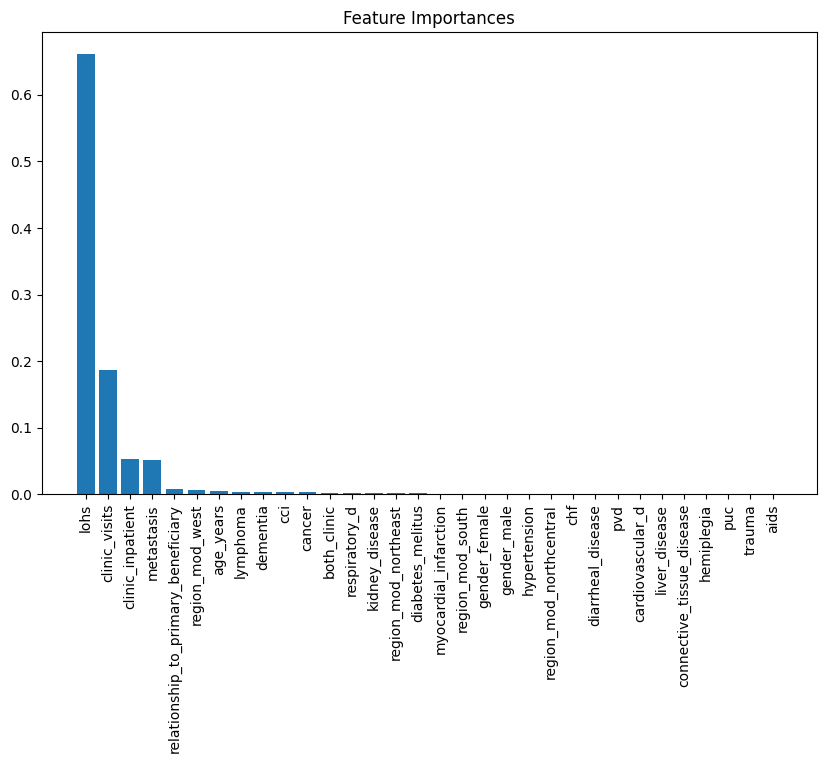

In [167]:
# Accessing feature importances
feature_importances = model.feature_importances_

# Match the feature names from your dataset
feature_names = X_train.columns

# Create a DataFrame for easy visualization
importances_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})

# Sort the DataFrame by importance
importances_df = importances_df.sort_values(by='importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(importances_df['feature'], importances_df['importance'])
plt.xticks(rotation='vertical')
plt.show()

In [17]:
from joblib import dump, load

dump(model, 'GradientBost_model.joblib')

['GradientBost_model.joblib']

In [18]:
model = load('GradientBost_model.joblib')

In [128]:
columns_to_convert = ['clinic_inpatient',
 'region_mod_northcentral',
 'region_mod_northeast',
 'region_mod_south',
 'region_mod_west',
 'gender_female',
 'gender_male',
 'both_clinic',
 'cci',
 'respiratory_d',
 'hypertension',
 'diabetes_melitus',
 'dementia',
 'kidney_disease',
 'liver_disease',
 'diarrheal_disease',
 'myocardial_infarction',
 'cardiovascular_d',
 'chf',
 'pvd',
 'cancer',
 'metastasis']  # List your columns here

for column in columns_to_convert:
    df[column] = df[column].astype(int)

(1626256, 32)

In [19]:
import pickle

# Assuming `model` is your trained machine learning model
with open('model.pkl', 'wb') as file:
    pickle.dump(gbm, file)